# pyhelios Demo: LiDAR simulation and visualisation

Notebook: Mark Searle, 2020, revised by Hannah Weiser, 2023

***

This notebook demos the excecution of a __LiDAR survey simulation__ using integrated Python functionalities to initiate __HELIOS++__.
The point cloud and the trajectory of the virtual scanner which can be configured to sit upon different moving or stationary platforms is then plotted using __matplotlib__.

***
The survey is configured through a __.xml survey file__ containing survey name, platform type, scanner type, and scene to be scanned along with platform and scanner settings.  
The simulation runs in several legs which represent individual scanner trajectories and are also configured from within the survey file.

The survey files are located within __'helios/data/surveys'__!

The __survey used in this demo__ (`custom_als_toyblocks.xml`) should be located in this folder.

***

In [1]:
# Imports
import time
import pyhelios
from pathlib import Path

In [2]:
import os
os.chdir("..")

In [3]:
# Survey to be used.
survey_path = 'toyblocks/custom_als_toyblocks.xml'

## LiDAR Simulation with PyHelios
__1st step - Initiate and run simulation. Access output using pyhelios functions:__

***

1. Configure simulation context and build a simulation:

In [4]:
# Sim context.
# Set logging.
pyhelios.loggingQuiet()
# Set seed for random number generator.
pyhelios.setDefaultRandomnessGeneratorSeed("123")

2. Load survey file:

In [5]:
from pyhelios import SimulationBuilder

simB = SimulationBuilder('data/surveys/' + survey_path, "assets/", "output/")
simB.setLasOutput(True)
simB.setZipOutput(False)
simB.setCallbackFrequency(100)
simB.setFinalOutput(True)

3. Run PyHelios simulation:

In [6]:
# Start the simulation.
sim = simB.build()
sim.start()

# Various simulation status functions available.
if sim.isStarted():
    print('Simulation has started!')

# Simulation can be paused with simulation.pause().
time.sleep(3)
sim.pause()

if sim.isPaused():
    print('Simulation is paused!')
    
if not sim.isRunning():
    print('Sim is not running.')
    
time.sleep(5)
sim.resume()

if sim.isRunning():
    print('Simulation has resumed!')

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.01529679998930078 seconds
Simulation has started!
Simulation is paused!
Sim is not running.
Simulation has resumed!


4. Process Output:

In [7]:
# Create instance of PyHeliosOutputWrapper class using sim.join(). 
# Contains attributes 'measurements' and 'trajectories' which are Python wrappers of classes that contain the output vectors.
output = sim.join()

print("{n} flight strips simulated and saved to file:".format(n=len(output.outpaths)))
for strip in output.outpaths:
    print(Path(strip).as_posix())

# Create instances of vector classes by accessing 'measurements' and 'trajectories' attributes of output wrapper.
measurements = output.measurements
trajectories = output.trajectories

# Get amount of points in trajectory and amount of measurements by accessing length of measurement and trajectory vectors.
print('\nNumber of measurements : {n}'.format(n=len(measurements)))
print('Number of points in trajectory : {n}'.format(n=len(trajectories)))

# Each element of vectors contains a measurement point or point in trajectory respectively. Access through getPosition().
# Get starting and end point of trajectory from first and last element of trajectory with getPosition() method.
starting_point = trajectories[0].getPosition()
end_point = trajectories[len(trajectories) - 1].getPosition()

# Output individual x, y and z vals.
# Accessed through x, y and z attributes of points from getPosition() method.
print('Trajectory starting point : ({x}, {y}, {z})'.format(
    x=starting_point.x, y=starting_point.y, z=starting_point.z))

print('Trajectory end point : ({x}, {y}, {z})'.format(
    x=end_point.x, y=end_point.y, z=end_point.z))

3 flight strips simulated and saved to file:
output/custom_als_toyblocks/2024-05-28_18-55-45/leg000_points.las
output/custom_als_toyblocks/2024-05-28_18-55-45/leg002_points.las
output/custom_als_toyblocks/2024-05-28_18-55-45/leg004_points.las

Number of measurements : 1783377
Number of points in trajectory : 30
Trajectory starting point : (-50.0, -50.0, 80.0)
Trajectory end point : (40.4488749992435, 50.000015918644785, 80.0)


## Plot Resulting Point Cloud and Trajectory
__2nd step: Survey scanner trajectory plot using matplotlib mplot3d:__

***

Here we can make use of the pyhelios function __outputToNumpy__, which saves both measurement and trajectory data as numpy arrays.

In [8]:
# Imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from pyhelios import outputToNumpy

1. Create numpy Array with points from trajectory using `outputToNumpy()`:

In [9]:
# Output is two np.arrays. One for measurements and one for trajectory points.
measurement_points, trajectory_points = outputToNumpy(output)

# Trajectory points to be plotted:
# First three cols are x, y and z vals
tpoints = trajectory_points[:,0:3]
# Measurement points to be plotted, only every 10th
# First three cols are x, y and z vals
mpoints = measurement_points[::10,0:3]
# color of measurements: 14th column is hitObjectId
c = measurement_points[::10,14]

2. 3D figure is created using mplot3d and the measurement and trajectory points are plotted onto 3D figure:

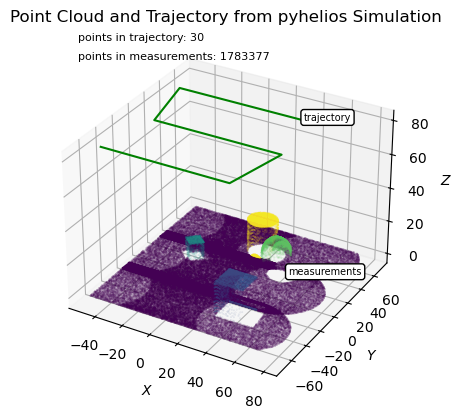

In [10]:
# Matplotlib figure.
fig = plt.figure()
# Axes3d axis onto mpl figure.
ax = fig.add_subplot(projection='3d')

# Plot scatter plot of measurements
ax.scatter(mpoints[:,0], mpoints[:,1], mpoints[:,2], s=0.05, alpha=0.2, c=c, label='points')

# Plot line plot of trajectory.
ax.plot(tpoints[:,0], tpoints[:,1], tpoints[:,2], c='green', label='scanner trajectory')
# Surface plot of groundplane.
# ax.plot_trisurf(groundplane[:,0], groundplane[:,1], groundplane[:,2], color='darkgoldenrod', label='groundplane')

# Add fancy labels to scatterplots (alternative to legend).
ax.text(tpoints[-1,0], tpoints[-1,1], tpoints[-1,2], 'trajectory',
        bbox = dict(boxstyle='round', fc='w', ec='k'), size='7')
ax.text(mpoints[-1,0], mpoints[-1,1], mpoints[-1,2], 'measurements',
        bbox = dict(boxstyle='round', fc='w', ec='k'), size='7')

# Add axis labels.
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

# Set title.
ax.set_title(label='Point Cloud and Trajectory from pyhelios Simulation')
# Set subtitle.
ax.text2D(0.1, 0.97, 'points in trajectory: {n}'.format(n=len(trajectories)), fontsize='8', transform=ax.transAxes)
ax.text2D(0.1, 0.92, 'points in measurements: {n}'.format(n=len(measurements)), fontsize='8', transform=ax.transAxes)
# Display results
plt.show()